In [104]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
np.set_printoptions(suppress=True)

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, precision_recall_curve, fbeta_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC, SVC

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.plotting import plot_decision_regions
%matplotlib inline
%precision 3

'%.3f'

In [2]:
with open('modeling_data','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.head(3)

,alcohol,noise,outdoor_seating,attire,good_for_groups,pricerange,takes_reservations,wifi,name,review_count,stars,michelin
1,beer_and_wine,average,False,'casual',True,2,True,no,Musashi Japanese Restaurant,170,4.0,0
105,beer_and_wine,average,True,u'casual',True,1,True,free,JJ's Red Hots - Dilworth,380,4.0,0
341,full_bar,loud,True,u'casual',True,2,True,free,Hickory Tavern,100,3.0,0


### A little bit of final cleaning to get data ready for modeling

In [4]:
df_mich = df.loc[df['michelin'] == 1]

In [5]:
df_mich.noise.value_counts()

Average    88
Quiet      41
Loud        3
Name: noise, dtype: int64

In [6]:
df['noise'].fillna('Average', inplace=True)

In [7]:
df_mich = df.loc[df['michelin'] == 1]

In [8]:
df_mich.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 151
Data columns (total 12 columns):
alcohol               145 non-null object
noise                 152 non-null object
outdoor_seating       147 non-null object
attire                147 non-null object
good_for_groups       151 non-null object
pricerange            152 non-null object
takes_reservations    151 non-null object
wifi                  131 non-null object
name                  152 non-null object
review_count          152 non-null int64
stars                 152 non-null float64
michelin              152 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 15.4+ KB


In [9]:
df['wifi'].fillna('No', inplace=True)

In [10]:
df['alcohol'].fillna('No', inplace=True)

In [11]:
df = df.dropna()

In [12]:
df.alcohol.value_counts()

full_bar         3674
none             2877
beer_and_wine    1406
FullBar           117
Beer&WineOnly      23
No                  4
Name: alcohol, dtype: int64

In [13]:
df.alcohol = df.alcohol.apply(lambda x: x.replace("FullBar", "full_bar"))
df.alcohol = df.alcohol.apply(lambda x: x.replace("Beer&WineOnly", "beer_and_wine"))
df.alcohol = df.alcohol.apply(lambda x: x.replace("No", "none"))

In [14]:
df.noise.value_counts()

average      6388
quiet        1056
loud          423
Average       100
very_loud      90
Quiet          41
Loud            3
Name: noise, dtype: int64

In [15]:
df.noise = df.noise.apply(lambda x: x.replace("Average", "average"))
df.noise = df.noise.apply(lambda x: x.replace("Quiet", "quiet"))
df.noise = df.noise.apply(lambda x: x.replace("Loud", "loud"))

In [16]:
df.outdoor_seating.value_counts()

True     4069
False    3888
No        117
Yes        27
Name: outdoor_seating, dtype: int64

In [17]:
df.outdoor_seating = df.outdoor_seating.apply(lambda x: x.replace("No", "False"))
df.outdoor_seating = df.outdoor_seating.apply(lambda x: x.replace("Yes", "True"))

In [18]:
df.attire.value_counts()

u'casual'                 4213
'casual'                  3438
u'dressy'                  161
'dressy'                   143
Dressy                      74
Casual                      66
Formal(JacketRequired)       4
u'formal'                    2
Name: attire, dtype: int64

In [19]:
df.attire = df.attire.apply(lambda x: x.replace("'", ""))
df.attire = df.attire.apply(lambda x: x.replace("ucasual", "casual"))
df.attire = df.attire.apply(lambda x: x.replace("udressy", "dressy"))
df.attire = df.attire.apply(lambda x: x.replace("uformal", "formal"))
df.attire = df.attire.apply(lambda x: x.replace("Dressy", "dressy"))
df.attire = df.attire.apply(lambda x: x.replace("Casual", "casual"))
df.attire = df.attire.apply(lambda x: x.replace("Formal(JacketRequired)", "formal"))

In [20]:
df.good_for_groups.value_counts()

True     7490
False     467
Yes       100
No         44
Name: good_for_groups, dtype: int64

In [21]:
df.good_for_groups = df.good_for_groups.apply(lambda x: x.replace("No", "False"))
df.good_for_groups = df.good_for_groups.apply(lambda x: x.replace("Yes", "True"))

In [22]:
df.pricerange = df.pricerange.astype(int)

In [23]:
df.pricerange = df.pricerange.astype(str)

In [24]:
df.pricerange.value_counts()

2    4780
1    2703
3     431
4     187
Name: pricerange, dtype: int64

In [25]:
df.takes_reservations.value_counts()

False    4566
True     3391
Yes       142
No          2
Name: takes_reservations, dtype: int64

In [26]:
df.takes_reservations = df.takes_reservations.apply(lambda x: x.replace("No", "False"))
df.takes_reservations = df.takes_reservations.apply(lambda x: x.replace("Yes", "True"))

In [27]:
df.wifi.value_counts()

free    4271
no      3686
No       113
Free      30
Paid       1
Name: wifi, dtype: int64

In [28]:
df = df.drop(df[df.wifi == 'Paid'].index)

In [29]:
df.wifi = df.wifi.apply(lambda x: x.replace("No", "no"))
df.wifi = df.wifi.apply(lambda x: x.replace("Free", "free"))

In [30]:
df.stars.value_counts()

4.0    2886
3.5    2236
4.5    1327
3.0    1062
2.5     398
2.0     112
5.0      55
1.5      24
Name: stars, dtype: int64

In [31]:
df = df.loc[df.stars >= 3.0]

In [32]:
df.stars = df.stars.astype(int)

In [33]:
df.stars = df.stars.astype(str)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7566 entries, 1 to 151
Data columns (total 12 columns):
alcohol               7566 non-null object
noise                 7566 non-null object
outdoor_seating       7566 non-null object
attire                7566 non-null object
good_for_groups       7566 non-null object
pricerange            7566 non-null object
takes_reservations    7566 non-null object
wifi                  7566 non-null object
name                  7566 non-null object
review_count          7566 non-null int64
stars                 7566 non-null object
michelin              7566 non-null int64
dtypes: int64(2), object(10)
memory usage: 768.4+ KB


In [35]:
df.stars.value_counts()

4    4213
3    3298
5      55
Name: stars, dtype: int64

### Dummy Data

In [36]:
df.head(3)

,alcohol,noise,outdoor_seating,attire,good_for_groups,pricerange,takes_reservations,wifi,name,review_count,stars,michelin
1,beer_and_wine,average,False,casual,True,2,True,no,Musashi Japanese Restaurant,170,4,0
105,beer_and_wine,average,True,casual,True,1,True,free,JJ's Red Hots - Dilworth,380,4,0
341,full_bar,loud,True,casual,True,2,True,free,Hickory Tavern,100,3,0


In [37]:
df = df.drop('name', axis = 1)

In [38]:
df_dummies = pd.get_dummies(df)

In [39]:
df_dummies.columns

Index(['review_count', 'michelin', 'alcohol_beer_and_wine', 'alcohol_full_bar',
       'alcohol_none', 'noise_average', 'noise_loud', 'noise_quiet',
       'noise_very_loud', 'outdoor_seating_False', 'outdoor_seating_True',
       'attire_casual', 'attire_dressy', 'attire_formal',
       'good_for_groups_False', 'good_for_groups_True', 'pricerange_1',
       'pricerange_2', 'pricerange_3', 'pricerange_4',
       'takes_reservations_False', 'takes_reservations_True', 'wifi_free',
       'wifi_no', 'stars_3', 'stars_4', 'stars_5'],
      dtype='object')

In [ ]:
with open('modeling_data_final', 'wb') as to_write:
    pickle.dump(df_dummies, to_write)

# kNN Model

In [41]:
df_modeling = df_dummies.copy()

In [42]:
X = df_modeling.drop(['michelin'], axis = 1)
y = df_modeling.michelin

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

y_pred = knn.predict(X_test)

print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))



The score for kNN is
Training:  99.97%
Test set:  97.95%
Recall:  0.2857142857142857
Precision:  0.2727272727272727


In [46]:
print('kNN')
confusion_matrix(y_test,y_pred)

kNN


array([[1477,   16],
       [  15,    6]])

#### Tuning the hyperparameter

In [47]:
# 10-fold cross-validation with K=7 for kNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.98  0.98  0.982 0.981 0.981 0.983 0.983 0.984 0.981 0.981]


In [48]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.9817613882257682


In [49]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.9714540492244976, 0.981629113093493, 0.9809677374321174, 0.9816294621043961, 0.9818940123689464, 0.9817613882257682, 0.9817613882257682, 0.9817613882257682, 0.9817613882257682, 0.9817613882257682, 0.9817613882257682, 0.9813649118398459, 0.9813649118398459, 0.9812326367075708, 0.9812326367075708, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956, 0.9811003615752956]


Text(0, 0.5, 'Cross-Validated Accuracy')

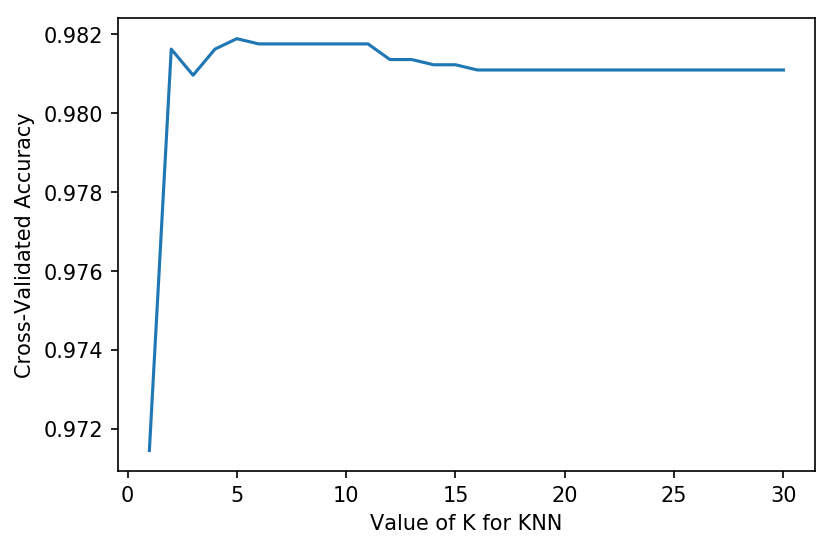

In [50]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(dpi=150)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#### It looks like the best value for k is around 6 neighbors

Text(0, 0.5, 'Cross-Validated Accuracy')

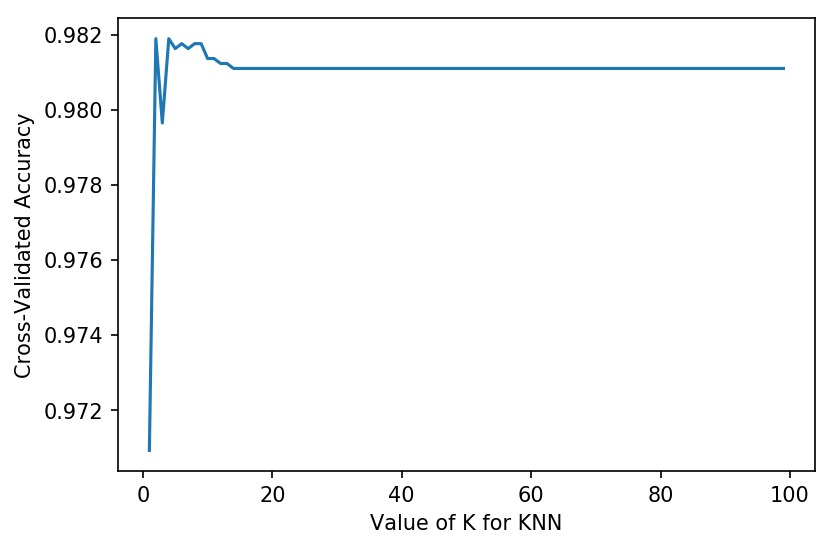

In [51]:
# now try with k-fold = 3 (cv parameter)

k_range = list(range(1, 100))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#### Grid Search

In [52]:
k_range = list(range(1, 100))

In [53]:
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


In [54]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [55]:
grid.fit(X, y);

In [56]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9818926777689664
{'n_neighbors': 4}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')


#### Randomized Grid Search

In [57]:
k_range = list(range(1, 100))

param_dist = dict(n_neighbors=k_range, weights=['uniform','distance'])

In [58]:
rand = RandomizedSearchCV(knn, param_dist, cv=7, scoring='accuracy', \
                          n_iter=40)
rand.fit(X, y);

In [59]:
print(rand.best_score_)
print(rand.best_params_)

0.9821570182394924
{'weights': 'uniform', 'n_neighbors': 5}


#### Printing out scores

In [60]:
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

[0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.981, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982]


# Logistic Regression

In [80]:
lm_log = LogisticRegression(solver= 'liblinear', C=500)
lm_log.fit(X_train, y_train)


LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
lm_log.score(X_train, y_train)

0.9849636483807006

In [82]:
y_pred_log = lm_log.predict(X_test)

print('Recall: ', recall_score(y_test, y_pred_log))
print('Precision: ', precision_score(y_test, y_pred_log))

Recall:  0.6666666666666666
Precision:  0.56


In [83]:
confusion_matrix(y_test,y_pred_log, labels=[1, 0])

array([[  14,    7],
       [  11, 1482]])

In [84]:
lm_log.coef_

array([[ 0.   ,  0.213,  0.135, -1.491,  0.108,  0.876, -0.277, -1.849,
        -0.359, -0.784, -0.522, -0.624,  0.004,  0.272, -1.415, -3.415,
        -1.899,  1.279,  2.892, -1.523,  0.381, -1.258,  0.116, -0.25 ,
         0.06 , -0.953]])

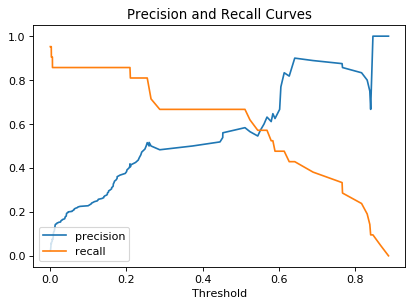

In [85]:
# Precision and Recall Curve

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm_log.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

# Naive Bayes

In [86]:
nb_bern = BernoulliNB()
nb_bern.fit(X_train, y_train)
print('Bernoulli Score')
nb_bern.score(X_test, y_test)

Bernoulli Score


0.9550858652575958

In [87]:
nb_gauss = GaussianNB()
nb_gauss.fit(X_train, y_train)
print('Gaussian Score')
nb_gauss.score(X_test, y_test)

Gaussian Score


0.929326287978864

In [88]:
nb_pred_gauss = nb_gauss.predict(X_test)
nb_pred_bern = nb_bern.predict(X_test)

print('Recall: ', recall_score(y_test, nb_pred_gauss))
print('Precision: ', precision_score(y_test, nb_pred_gauss))
print('F1 score: ', f1_score(nb_gauss.predict(X_test), y_test))

Recall:  0.8571428571428571
Precision:  0.14754098360655737
F1 score:  0.2517482517482518


In [89]:
print('Confusion Matrix for Bernoulli')
confusion_matrix(y_test, nb_pred_bern, labels = [1,0])

Confusion Matrix for Bernoulli


array([[  17,    4],
       [  64, 1429]])

In [90]:
print('Confusion Matrix for Gaussian')
confusion_matrix(y_test, nb_pred_gauss, labels = [1,0])

Confusion Matrix for Gaussian


array([[  18,    3],
       [ 104, 1389]])

## Tree Model

In [91]:
def quick_test_seeded(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=30)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_multiple(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [92]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
model_tree.score(X_test, y_test)

0.97556142668428

In [93]:
tree_pred = model_tree.predict(X_test)

In [94]:
confusion_matrix(y_test, tree_pred, labels = [1,0])

array([[  11,   10],
       [  27, 1466]])

## Random Forest

In [95]:
model_forest = RandomForestClassifier(n_estimators=100)
model_forest.fit(X_train, y_train)
model_forest.score(X_test, y_test)

0.9854689564068693

In [96]:
forest_pred = model_forest.predict(X_test)

In [97]:
confusion_matrix(y_test, forest_pred, labels = [1,0])

array([[  13,    8],
       [  14, 1479]])

## Naive Oversampling

In [98]:
y_train.value_counts()

0    5930
1     122
Name: michelin, dtype: int64

In [102]:
ROS = RandomOverSampler(random_state=30)

X_train_rs, y_train_rs = ROS.fit_sample(X_train, y_train)

lr = LogisticRegression() 
lr.fit(X_train, y_train)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

lr_os = LogisticRegression() 
lr_os.fit(X_train_rs, y_train_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_os.predict(X_test)), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))

Simple Logistic Regression; Test F1: 0.591, Test AUC: 0.947
Logistic Regression on Oversampled Train Data; Test F1: 0.245, Test AUC: 0.948


/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [114]:
confusion_matrix(y, lr_os.predict(X))

array([[6911,  512],
       [  12,  131]])

## Synthetic Oversampling

In [105]:
smote = SMOTE(random_state = 30)
    
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

lr_smote = LogisticRegression() 
lr_smote.fit(X_train_smote, y_train_smote)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_smote.predict(X_test), y_test), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))

Simple Logistic Regression; Test F1: 0.591, Test AUC: 0.947
Logistic Regression on SMOTE Train Data; Test F1: 0.416, Test AUC: 0.943


/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [115]:
confusion_matrix(y, lr_smote.predict(X))

array([[7244,  179],
       [  39,  104]])

### ADASYN

In [106]:
X_train_ada, y_train_ada = ADASYN(random_state=30).fit_sample(X_train,y_train)

In [107]:
Counter(y_train_ada)

Counter({0: 5930, 1: 5927})

In [108]:
model_ada = SVC().fit(X_train_ada, y_train_ada)

/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [109]:
lr_ada = LogisticRegression() 
lr_ada.fit(X_train_ada, y_train_ada)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

print('Logistic Regression on ADASYN Train Data; Test F1: %.3f' % \
      (f1_score(model_ada.predict(X_test), y_test)))

/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Simple Logistic Regression; Test F1: 0.591, Test AUC: 0.947
Logistic Regression on ADASYN Train Data; Test F1: 0.168


In [110]:
confusion_matrix(y, model_ada.predict(X))

array([[7089,  334],
       [  17,  126]])

## Undersampling

In [113]:
RUS = RandomUnderSampler(random_state = 30)
    
X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)

lr_RUS = LogisticRegression()
nb_RUS = GaussianNB()
nb_RUS.fit(X_tr_RUS, y_tr_RUS)
lr_RUS.fit(X_tr_RUS, y_tr_RUS)

print('Logistic Regression on Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
     (f1_score(lr_RUS.predict(X_test), y_test), roc_auc_score(y_test, lr_RUS.predict_proba(X_test)[:,1])))
print('Bayesian on Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
     (f1_score(nb_RUS.predict(X_test), y_test), roc_auc_score(y_test, nb_RUS.predict_proba(X_test)[:,1])))

Logistic Regression on Undersampled Train Data; Test F1: 0.222, Test AUC: 0.943
Bayesian on Undersampled Train Data; Test F1: 0.252, Test AUC: 0.955


/Users/lawrencewang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [116]:
confusion_matrix(y, lr_RUS.predict(X))

array([[6832,  591],
       [   8,  135]])